In [1]:
# path of dataset file
import os
dataset = "D:/Working papers/Colon Diesease/Datasets/kvasir-seg/Kvasir-SEG/images-preprocessed/"
print(os.listdir(dataset))


['adenomatous', 'hyperplastic']


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

import numpy as np

from deap import base, creator, tools, algorithms
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, hinge_loss
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# Load the pretrained EfficientNet model
efficientnet = models.efficientnet_b0(pretrained=True)

# Remove the final classification layer to use the model for feature extraction
efficientnet = nn.Sequential(*list(efficientnet.children())[:-1])

# Set the model to evaluation mode
efficientnet.eval()

# Define a transform to preprocess the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def extract_features(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()

D:\Implementation\ColonCancer\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Implementation\ColonCancer\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
classes = os.listdir(dataset)
# Extract features and labels
features_list = []
labels_list = []

for label, class_dir in enumerate(classes):
    class_path = os.path.join(dataset, class_dir)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        features = extract_features(image_path, efficientnet)
        features_list.append(features)
        labels_list.append(label)


features = np.vstack(features_list)
labels = np.hstack(labels_list)

print(f'Features shape: {features.shape}')
print(f'Features shape: {features.shape}')

print(f'Features shape: {features.shape}')
print(f'Number of features extracted per image: {features.shape[1]}')


Features shape: (1000, 1280)
Features shape: (1000, 1280)
Features shape: (1000, 1280)
Number of features extracted per image: 1280


In [5]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import joblib
import multiprocessing



In [6]:
# Initialize lists to store accuracy and loss
train_accuracy_svm_list = []
validation_accuracy_svm_list = []
train_loss_svm_list = []
validation_loss_svm_list = []
selected_feature_counts = []  # List to store feature counts after selection

class FeatureSelectionProblem(Problem):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        super().__init__(n_var=features.shape[1], n_obj=1, xl=0, xu=1, type_var=np.bool_)

    def _evaluate(self, x, out, *args, **kwargs):
        res = []
        for individual in x:
            selected_features = np.where(individual)[0]
             # Count and store the number of selected features for each individual
            selected_feature_counts.append(len(selected_features))
            
            if len(selected_features) == 0:
                res.append([0])  # Invalid solution
                continue
            X_train, X_test, y_train, y_test = train_test_split(self.features[:, selected_features], self.labels, test_size=0.3, random_state=42)

            # SVM
            svm = SVC(kernel='poly')
            svm.fit(X_train, y_train)

            # Calculate training accuracy
            y_train_pred = svm.predict(X_train)
            train_accuracy_svm = accuracy_score(y_train, y_train_pred)
            train_accuracy_svm_list.append(train_accuracy_svm * 100)
            #print(f"Train Accuracy SVM: {train_accuracy_svm * 100:.2f}%") 

            # Calculate validation accuracy
            y_test_pred = svm.predict(X_test)
            validation_accuracy_svm = accuracy_score(y_test, y_test_pred)
            validation_accuracy_svm_list.append(validation_accuracy_svm * 100)
            #print(f"Validation Accuracy SVM: {validation_accuracy_svm * 100:.2f}%")

            # Calculate training and validation loss
            train_loss_svm = hinge_loss(y_train, svm.decision_function(X_train))
            validation_loss_svm = hinge_loss(y_test, svm.decision_function(X_test))
            train_loss_svm_list.append(train_loss_svm)
            validation_loss_svm_list.append(validation_loss_svm)
            #print(f"Train Loss SVM: {train_loss_svm * 100:.2f}")
            #print(f"Validation Loss SVM: {validation_loss_svm * 100:.2f}")

            res.append([1 - validation_accuracy_svm])

        out['F'] = np.array(res)

In [7]:

problem = FeatureSelectionProblem(features, labels)



In [8]:
# Parallel processing setup
pool = multiprocessing.Pool()
toolbox = base.Toolbox()
toolbox.register("map", pool.map)


In [9]:
algorithm = NSGA2(pop_size=25,
                  sampling=BinaryRandomSampling(),
                  crossover=TwoPointCrossover(),
                  mutation=BitflipMutation(),
                  eliminate_duplicates=True)


In [10]:

res = minimize(problem,
               algorithm,
               ('n_gen', 25),
               seed=1,
               save_history=True,
               verbose=True,
                eliminate_duplicates=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       25 |      2 |             - |             -
     2 |       50 |      3 |  0.000000E+00 |             f
     3 |       75 |      2 |  0.0066666667 |         ideal
     4 |      100 |      5 |  0.000000E+00 |             f
     5 |      125 |      1 |  0.0066666667 |         ideal
     6 |      150 |      1 |  0.0033333333 |         ideal
     7 |      175 |      2 |  0.000000E+00 |             f
     8 |      200 |      3 |  0.000000E+00 |             f
     9 |      225 |      3 |  0.0033333333 |         ideal
    10 |      250 |      5 |  0.000000E+00 |             f
    11 |      275 |     10 |  0.000000E+00 |             f
    12 |      300 |      1 |  0.0033333333 |         ideal
    13 |      325 |      2 |  0.0033333333 |         ideal
    14 |      350 |      1 |  0.0033333333 |         ideal
    15 |      375 |      2 |  0.000000E+00 |             f
    16 |      400 |      6 |  0.000000E+00 |            

In [11]:
# After optimization, print the feature counts
print("Selected feature counts after NSGA-II for each solution:")
for i, count in enumerate(selected_feature_counts, start=1):
    print(f"Solution {i}: {count} features selected")

Selected feature counts after NSGA-II for each solution:
Solution 1: 635 features selected
Solution 2: 625 features selected
Solution 3: 646 features selected
Solution 4: 637 features selected
Solution 5: 596 features selected
Solution 6: 689 features selected
Solution 7: 654 features selected
Solution 8: 622 features selected
Solution 9: 633 features selected
Solution 10: 636 features selected
Solution 11: 610 features selected
Solution 12: 629 features selected
Solution 13: 653 features selected
Solution 14: 621 features selected
Solution 15: 608 features selected
Solution 16: 640 features selected
Solution 17: 633 features selected
Solution 18: 639 features selected
Solution 19: 650 features selected
Solution 20: 639 features selected
Solution 21: 680 features selected
Solution 22: 653 features selected
Solution 23: 646 features selected
Solution 24: 614 features selected
Solution 25: 655 features selected
Solution 26: 650 features selected
Solution 27: 632 features selected
Solutio

In [12]:
# Print selected feature counts per image
print("Number of selected features for each image after NSGA-II:")
for i, count in enumerate(selected_feature_counts, start=1):
    print(f"Image {i}: {count} features selected")

Number of selected features for each image after NSGA-II:
Image 1: 635 features selected
Image 2: 625 features selected
Image 3: 646 features selected
Image 4: 637 features selected
Image 5: 596 features selected
Image 6: 689 features selected
Image 7: 654 features selected
Image 8: 622 features selected
Image 9: 633 features selected
Image 10: 636 features selected
Image 11: 610 features selected
Image 12: 629 features selected
Image 13: 653 features selected
Image 14: 621 features selected
Image 15: 608 features selected
Image 16: 640 features selected
Image 17: 633 features selected
Image 18: 639 features selected
Image 19: 650 features selected
Image 20: 639 features selected
Image 21: 680 features selected
Image 22: 653 features selected
Image 23: 646 features selected
Image 24: 614 features selected
Image 25: 655 features selected
Image 26: 650 features selected
Image 27: 632 features selected
Image 28: 661 features selected
Image 29: 617 features selected
Image 30: 624 features 

In [13]:
# Print the results as a table
from tabulate import tabulate
table = [
    [i+1, train_accuracy, val_accuracy, train_loss, val_loss]
    for i, (train_accuracy, val_accuracy, train_loss, val_loss) 
    in enumerate(zip(train_accuracy_svm_list, validation_accuracy_svm_list, train_loss_svm_list, validation_loss_svm_list))
]
headers = ["Iteration", "Training Accuracy (%)", "Validation Accuracy (%)", "Training Loss", "Validation Loss"]
print(tabulate(table, headers=headers, tablefmt="grid"))

+-------------+-------------------------+---------------------------+-----------------+-------------------+
|   Iteration |   Training Accuracy (%) |   Validation Accuracy (%) |   Training Loss |   Validation Loss |
+=============+=========================+===========================+=================+===================+
|           1 |                 98.1429 |                   87      |       0.110836  |          0.359663 |
+-------------+-------------------------+---------------------------+-----------------+-------------------+
|           2 |                 97.1429 |                   88.6667 |       0.120193  |          0.359698 |
+-------------+-------------------------+---------------------------+-----------------+-------------------+
|           3 |                 97.7143 |                   89      |       0.111889  |          0.343297 |
+-------------+-------------------------+---------------------------+-----------------+-------------------+
|           4 |             

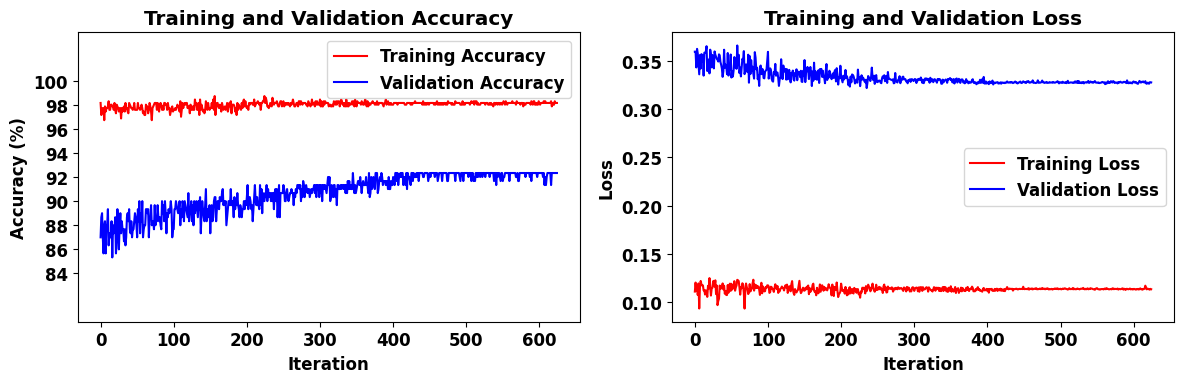

In [14]:
import matplotlib.pyplot as plt

# Set font size and weight for all text in the plot
plt.rcParams.update({
    'font.size': 12,      # Font size
    'font.weight': 'bold' # Font weight
})

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_svm_list, label='Training Accuracy', color='red')
plt.plot(validation_accuracy_svm_list, label='Validation Accuracy', color='blue')
plt.ylim(80, 104)  # Set y-axis range from 80 to 100
plt.yticks(np.arange(84, 102, 2))  # Step size of 2 for y-axis ticks
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Training and Validation Accuracy', fontweight='bold')
plt.legend()
#plt.yticks(range(70, len(train_accuracy_svm_list) + 1, 20))  # Set x-axis ticks with step size of 20

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
#plt.figure(figsize=(12, 5))
plt.plot(train_loss_svm_list, label='Training Loss', color='red')
plt.plot(validation_loss_svm_list, label='Validation Loss', color='blue')
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.title('Training and Validation Loss', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()



In [15]:
# Extract best individuals
best_individuals = res.X
best_individual = best_individuals[0]
selected_features = np.where(best_individual)[0]
print(f'Selected Features: {selected_features}')

Selected Features: [   0    1    2    5    6    8   10   11   12   19   23   24   25   30
   32   33   43   44   46   47   48   50   55   57   62   63   65   68
   71   72   73   76   80   81   83   84   85   91   96   97   98  102
  104  108  110  111  114  116  118  119  122  124  126  128  129  130
  131  132  135  138  140  145  146  148  149  154  161  162  163  164
  165  166  168  176  177  180  182  183  185  186  189  191  192  194
  196  198  199  200  203  204  208  209  210  212  213  216  219  220
  222  224  225  227  230  233  234  235  238  239  245  246  247  250
  251  253  254  256  258  259  263  264  266  267  270  272  278  284
  285  286  287  290  291  296  299  301  302  303  304  305  306  308
  310  311  312  313  316  318  320  325  326  328  330  331  333  335
  336  339  341  345  346  348  349  350  351  352  355  356  357  358
  364  367  369  372  373  374  375  377  378  379  380  381  382  385
  389  391  394  398  399  401  402  403  404  408  409  4

In [16]:
# Select features based on NSGA-II results
X_selected = features[:, selected_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, labels_list, test_size=0.3, random_state=42)



SVM Accuracy: 0.9233
SVM Precision: 0.9264
SVM Recall: 0.9321
SVM F1 Score: 0.9292
SVM AUC: 0.9642


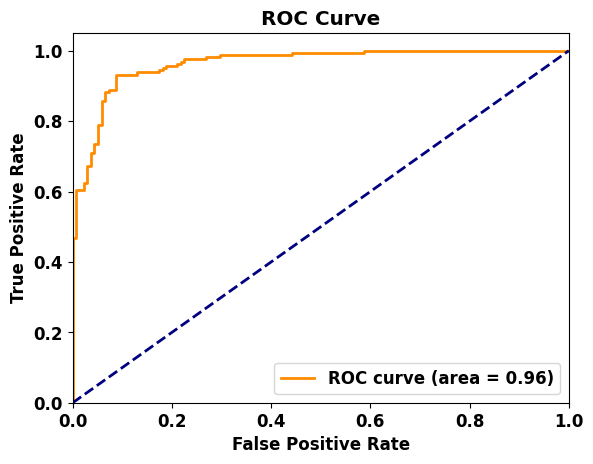

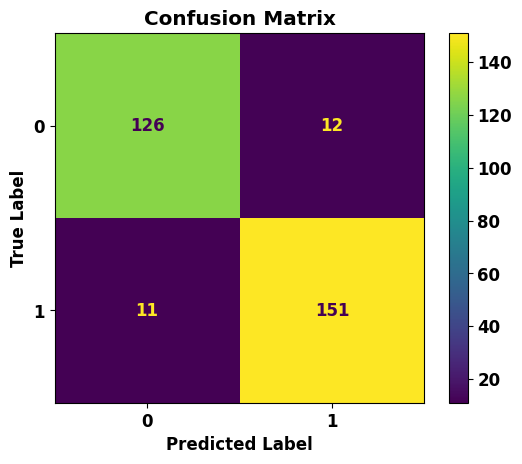

In [17]:
# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontweight='bold')
    plt.ylabel('True Positive Rate', fontweight='bold')
    plt.title(title, fontweight='bold')
    plt.legend(loc="lower right")
    plt.show()

# Train and evaluate SVM
svm = SVC(kernel='poly', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_score_svm = svm.decision_function(X_test)

# Compute metrics for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

print(f'SVM Accuracy: {accuracy_svm:.4f}')
print(f'SVM Precision: {precision_svm:.4f}')
print(f'SVM Recall: {recall_svm:.4f}')
print(f'SVM F1 Score: {f1_svm:.4f}')
print(f'SVM AUC: {roc_auc_svm:.4f}')

# Plot ROC curve for SVM
plot_roc_curve(fpr_svm, tpr_svm, roc_auc_svm, 'ROC Curve')

# Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()
plt.title('Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.show()

In [18]:

# Don't forget to close the pool when you're done
pool.close()
pool.join()